In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects


file_path = r"E:\Projects\Gamezone Orders Data\Data\Cleaned\gamezone_orders_data_cleaned.csv"
df = pd.read_csv(
    file_path,
    parse_dates=['purchase_ts_cleaned', 'ship_ts'],
    dtype={
        'purchase_year': 'Int64',
        'purchase_month': 'Int64',
        'time_to_ship': 'Int64',
        'revenue': 'float'
    },
    encoding='utf-8',
    keep_default_na=False,
    na_values=['']  # Only treat empty strings as NaN
)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21864 entries, 0 to 21863
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   user_id                          21864 non-null  object        
 1   order_id                         21864 non-null  object        
 2   purchase_ts                      21864 non-null  object        
 3   purchase_ts_cleaned              21863 non-null  datetime64[ns]
 4   purchase_year                    21864 non-null  Int64         
 5   purchase_month                   21864 non-null  Int64         
 6   time_to_ship                     21864 non-null  Int64         
 7   ship_ts                          21864 non-null  datetime64[ns]
 8   product_name                     21864 non-null  object        
 9   product_name_cleaned             21864 non-null  object        
 10  product_id                       21864 non-null  object   

In [6]:
import pandas as pd

# Assuming df is your cleaned orders dataframe
# Ensure purchase_ts_cleaned is datetime
df['purchase_ts_cleaned'] = pd.to_datetime(df['purchase_ts_cleaned'])

# 1️⃣ Create a cohort column — first purchase month per user
first_purchase = (
    df.groupby('user_id')['purchase_ts_cleaned']
    .min()
    .dt.to_period('M')
    .rename('cohort')
)

df = df.join(first_purchase, on='user_id')

# 2️⃣ Count purchases per user
user_purchase_counts = df.groupby('user_id')['order_id'].nunique().rename('purchase_count')

# 3️⃣ Merge back with cohort info
user_data = df[['user_id', 'cohort']].drop_duplicates().merge(user_purchase_counts, on='user_id')

# 4️⃣ Calculate repeat purchase rate per cohort
rpr = (
    user_data.groupby('cohort')
    .apply(lambda x: (x['purchase_count'] >= 2).mean() * 100)
    .reset_index(name='repeat_purchase_rate_%')
)

# 5️⃣ Sort and clean for display
rpr['cohort'] = rpr['cohort'].astype(str)
rpr = rpr.sort_values('cohort').reset_index(drop=True)

print(rpr)


     cohort  repeat_purchase_rate_%
0   2019-01               14.797136
1   2019-02                5.345912
2   2019-03                4.280156
3   2019-04                4.406130
4   2019-05                3.434343
5   2019-06                3.640257
6   2019-07               13.078471
7   2019-08               11.284047
8   2019-09               19.366197
9   2019-10                5.010438
10  2019-11               14.020270
11  2019-12               19.908815
12  2020-01               12.631579
13  2020-02                3.291536
14  2020-03                2.564103
15  2020-04                3.889369
16  2020-05                2.350966
17  2020-06                3.187614
18  2020-07                7.714286
19  2020-08               10.488246
20  2020-09               16.025641
21  2020-10                3.093812
22  2020-11               10.157618
23  2020-12               19.304734
24  2021-01               31.241473
25  2021-02                0.240964


C:\Users\shaif\AppData\Local\Temp\ipykernel_19772\452118629.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['purchase_count'] >= 2).mean() * 100)


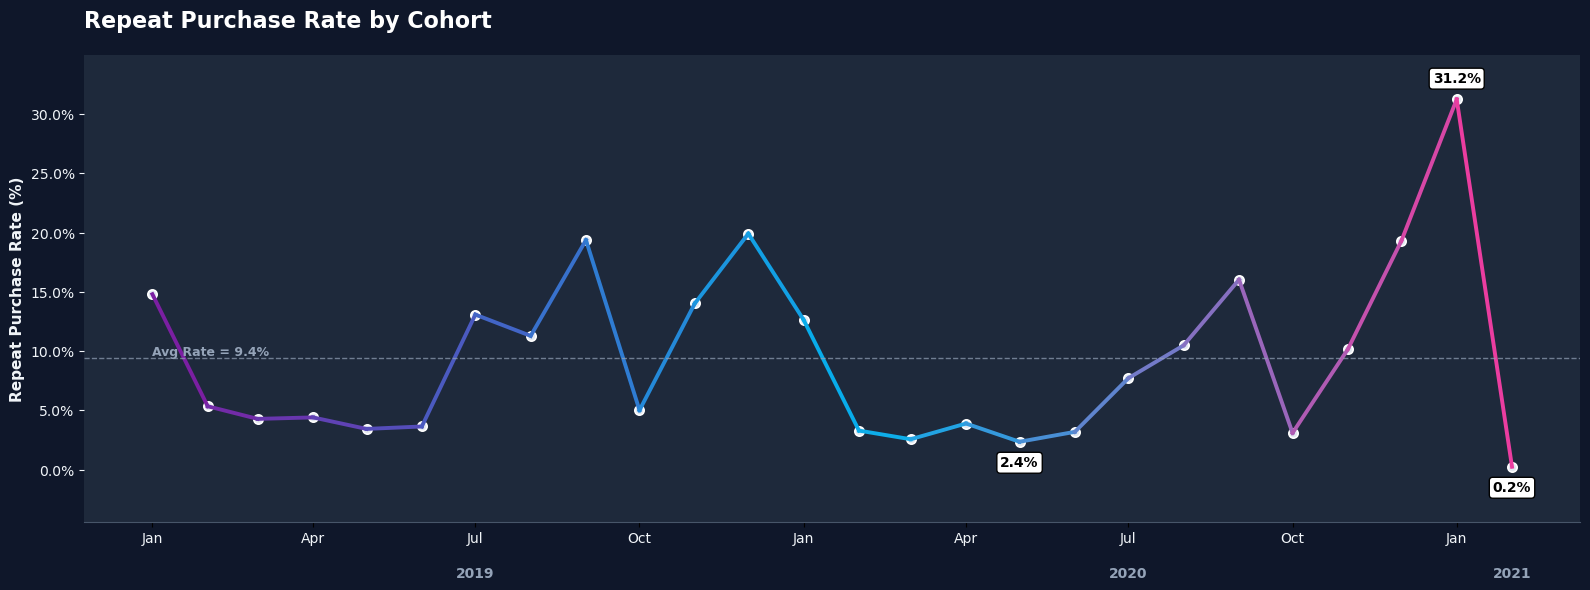

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Prepare data
rpr['cohort'] = pd.to_datetime(rpr['cohort'], format='%Y-%m')
rpr = rpr.sort_values('cohort')

# Identify highest, lowest, and 2nd lowest
highest = rpr.nlargest(1, 'repeat_purchase_rate_%')
lowest = rpr.nsmallest(1, 'repeat_purchase_rate_%')
second_lowest = rpr.nsmallest(2, 'repeat_purchase_rate_%').iloc[1:]

# Your 3-color palette (Purple → Blue → Pink)
colors = ["#7B1FA2", "#03b2ed", "#FF3399"]

# Create gradient colormap for line
cmap = LinearSegmentedColormap.from_list("rpr_grad", colors)

# Normalize for gradient mapping
n = len(rpr)
gradient_colors = [cmap(i / (n - 1)) for i in range(n)]

fig, ax = plt.subplots(figsize=(16, 6))

# DARK SLATE/NAVY BACKGROUND
fig.patch.set_facecolor('#0f172a')
ax.set_facecolor('#1e293b')

# ---- GRADIENT LINE ----
for i in range(n - 1):
    ax.plot(
        rpr["cohort"].iloc[i:i+2],
        rpr["repeat_purchase_rate_%"].iloc[i:i+2],
        color=gradient_colors[i],
        linewidth=2.8
    )

# Markers
ax.scatter(
    rpr["cohort"],
    rpr["repeat_purchase_rate_%"],
    color="#e2e8f0",
    s=45,
    edgecolors="white",
    linewidth=1.2
)

# ---- TITLE ----
ax.set_title(
    "Repeat Purchase Rate by Cohort",
    fontsize=16,
    fontweight="bold",
    loc="left",
    color="white",
    pad=20
)

ax.set_xlabel("")

# ---- Y-AXIS (VISIBLE) ----
ax.set_ylabel("Repeat Purchase Rate (%)", color="#f1f5f9", fontsize=11, fontweight='bold')
ax.tick_params(axis="y", colors="#f1f5f9")
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.1f}%'))

# ---- Quarter Ticks ----
quarter_mask = rpr["cohort"].dt.month.isin([1, 4, 7, 10])
quarter_data = rpr[quarter_mask]

plt.xticks(
    quarter_data["cohort"],
    quarter_data["cohort"].dt.strftime('%b'),
    fontsize=10,
    color="#f1f5f9"
)

# ---- Borders ----
for spine in ["top", "left", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["bottom"].set_color("#475569")

# ---- Y-range padding ----
ymin, ymax = rpr["repeat_purchase_rate_%"].min(), rpr["repeat_purchase_rate_%"].max()
ax.set_ylim(
    ymin - (ymax - ymin) * 0.15,
    ymax + (ymax - ymin) * 0.12
)

# ---- Avg Rate ----
avg_rate = rpr['repeat_purchase_rate_%'].mean()
ax.axhline(avg_rate, color="#94a3b8", linestyle="--", linewidth=1, alpha=0.7)
ax.text(
    rpr['cohort'].iloc[0],
    avg_rate * 1.02,
    f"Avg Rate = {avg_rate:.1f}%",
    color="#94a3b8",
    fontsize=9,
    fontweight="bold"
)

# ---- Highest & Lowest & 2nd Lowest Labels ----
# Highest
for _, row in highest.iterrows():
    ax.annotate(
        f"{row['repeat_purchase_rate_%']:.1f}%",
        xy=(row["cohort"], row["repeat_purchase_rate_%"]),
        xytext=(0, 12),
        textcoords="offset points",
        ha="center",
        fontsize=10,
        fontweight="bold",
        color="#000000",
        bbox=dict(boxstyle="round,pad=0.25", edgecolor="black", facecolor="white")
    )

# Lowest
for _, row in lowest.iterrows():
    ax.annotate(
        f"{row['repeat_purchase_rate_%']:.1f}%",
        xy=(row["cohort"], row["repeat_purchase_rate_%"]),
        xytext=(0, -18),
        textcoords="offset points",
        ha="center",
        fontsize=10,
        fontweight="bold",
        color="#000000",
        bbox=dict(boxstyle="round,pad=0.25", edgecolor="black", facecolor="white")
    )

# 2nd Lowest
for _, row in second_lowest.iterrows():
    ax.annotate(
        f"{row['repeat_purchase_rate_%']:.1f}%",
        xy=(row["cohort"], row["repeat_purchase_rate_%"]),
        xytext=(0, -18),
        textcoords="offset points",
        ha="center",
        fontsize=10,
        fontweight="bold",
        color="#000000",
        bbox=dict(boxstyle="round,pad=0.25", edgecolor="black", facecolor="white")
    )

# ---- Year labels below chart ----
years = rpr["cohort"].dt.year.unique()
for yr in years:
    yd = rpr[rpr['cohort'].dt.year == yr]
    mid_month = yd["cohort"].iloc[len(yd)//2]
    ax.text(
        mid_month,
        ymin - (ymax - ymin) * 0.30,
        str(yr),
        ha="center",
        fontsize=10,
        fontweight="bold",
        color="#94a3b8"
    )

plt.tight_layout()
plt.show()

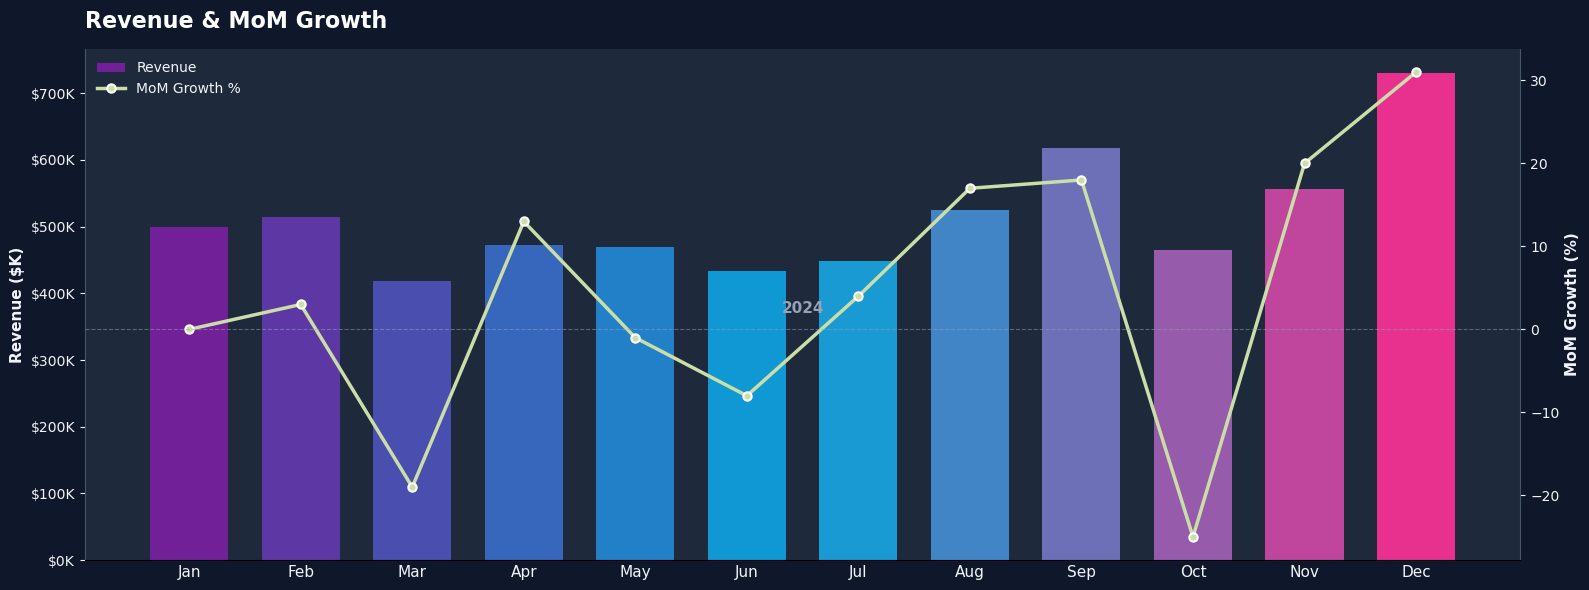

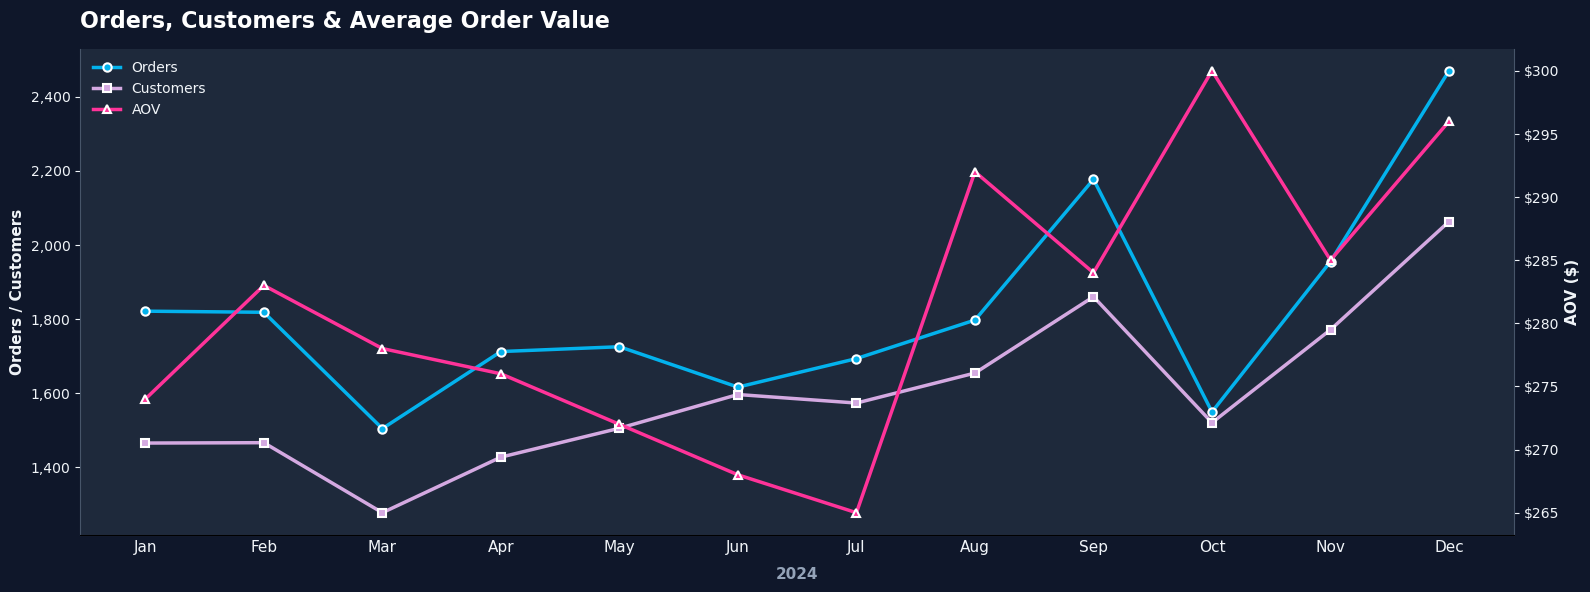

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Data
data = {
    'month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'revenue': [500, 515, 418, 473, 469, 433, 449, 525, 618, 465, 557, 730],
    'orders': [1821, 1818, 1504, 1712, 1725, 1616, 1693, 1797, 2177, 1549, 1955, 2470],
    'customers': [1465, 1466, 1277, 1427, 1505, 1596, 1573, 1654, 1860, 1520, 1771, 2063],
    'aov': [274, 283, 278, 276, 272, 268, 265, 292, 284, 300, 285, 296],
    'mom': [None, 3, -19, 13, -1, -8, 4, 17, 18, -25, 20, 31]
}

df = pd.DataFrame(data)
x = np.arange(len(df['month']))

# Your 3-color palette
PURPLE = "#7B1FA2"
BLUE = "#03b2ed"
PINK = "#FF3399"
LAVENDER = "#D4A9E1"
LIME = "#CCDEA7"

# ===== CHART 1: REVENUE & MOM GROWTH =====
fig1, ax1 = plt.subplots(figsize=(16, 6))

# DARK SLATE/NAVY BACKGROUND
fig1.patch.set_facecolor('#0f172a')
ax1.set_facecolor('#1e293b')

# Gradient bars for revenue
colors = [PURPLE, BLUE, PINK]
cmap = LinearSegmentedColormap.from_list("revenue_grad", colors)
n = len(df)
bar_colors = [cmap(i / (n - 1)) for i in range(n)]

# Revenue bars
bars = ax1.bar(x, df['revenue'], color=bar_colors, alpha=0.9, width=0.7, label='Revenue')

# MoM Growth line (secondary axis)
ax1_right = ax1.twinx()
mom_data = df['mom'].fillna(0)
ax1_right.plot(x, mom_data, color=LIME, marker='o', markersize=6, 
               markeredgecolor="white", linewidth=2.5, label='MoM Growth %', markeredgewidth=1.5)

# Title
ax1.set_title(
    "Revenue & MoM Growth",
    fontsize=16,
    fontweight="bold",
    loc="left",
    color="white",
    pad=15
)

# X-axis
ax1.set_xticks(x)
ax1.set_xticklabels(df['month'], fontsize=11, color="#f1f5f9")
ax1.tick_params(axis='x', length=0)

# Y-axis (Revenue)
ax1.set_ylabel("Revenue ($K)", color="#f1f5f9", fontsize=11, fontweight='bold')
ax1.tick_params(axis="y", colors="#f1f5f9")
ax1.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:.0f}K'))

# Y-axis (MoM %)
ax1_right.set_ylabel("MoM Growth (%)", color="#f1f5f9", fontsize=11, fontweight='bold')
ax1_right.tick_params(axis="y", colors="#f1f5f9")
ax1_right.axhline(0, color="#94a3b8", linestyle="--", linewidth=0.8, alpha=0.5)

# Spines
for spine in ["top"]:
    ax1.spines[spine].set_visible(False)
    ax1_right.spines[spine].set_visible(False)
ax1.spines["bottom"].set_color("#475569")
ax1.spines["left"].set_color("#475569")
ax1.spines["right"].set_visible(False)
ax1_right.spines["right"].set_color("#475569")
ax1_right.spines["left"].set_visible(False)

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_right.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, 
          loc="upper left", fontsize=10, frameon=False, labelcolor="#f1f5f9")

# Year label below chart
ymin = min(df['revenue'])
ymax = max(df['revenue'])
ax1.text(
    len(df) / 2 - 0.5,
    ymin - (ymax - ymin) * 0.15,
    "2024",
    ha="center",
    fontsize=11,
    fontweight="bold",
    color="#94a3b8"
)

plt.tight_layout()
plt.show()

# ===== CHART 2: ORDERS, CUSTOMERS & AOV =====
fig2, ax2 = plt.subplots(figsize=(16, 6))

# DARK SLATE/NAVY BACKGROUND
fig2.patch.set_facecolor('#0f172a')
ax2.set_facecolor('#1e293b')

# Secondary axis for AOV
ax2_right = ax2.twinx()

# Orders line
ax2.plot(x, df['orders'], color=BLUE, marker='o', markersize=6, 
         markeredgecolor="white", linewidth=2.5, label='Orders', markeredgewidth=1.5)

# Customers line
ax2.plot(x, df['customers'], color=LAVENDER, marker='s', markersize=6, 
         markeredgecolor="white", linewidth=2.5, label='Customers', markeredgewidth=1.5)

# AOV line (on secondary axis)
ax2_right.plot(x, df['aov'], color=PINK, marker='^', markersize=6, 
               markeredgecolor="white", linewidth=2.5, label='AOV', markeredgewidth=1.5)

# Title
ax2.set_title(
    "Orders, Customers & Average Order Value",
    fontsize=16,
    fontweight="bold",
    loc="left",
    color="white",
    pad=15
)

# X-axis
ax2.set_xticks(x)
ax2.set_xticklabels(df['month'], fontsize=11, color="#f1f5f9")
ax2.tick_params(axis='x', length=0)

# Y-axis (Orders/Customers)
ax2.set_ylabel("Orders / Customers", color="#f1f5f9", fontsize=11, fontweight='bold')
ax2.tick_params(axis="y", colors="#f1f5f9")
ax2.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Y-axis (AOV)
ax2_right.set_ylabel("AOV ($)", color="#f1f5f9", fontsize=11, fontweight='bold')
ax2_right.tick_params(axis="y", colors="#f1f5f9")
ax2_right.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:.0f}'))

# Spines
for spine in ["top"]:
    ax2.spines[spine].set_visible(False)
    ax2_right.spines[spine].set_visible(False)
ax2.spines["bottom"].set_color("#475569")
ax2.spines["left"].set_color("#475569")
ax2.spines["right"].set_visible(False)
ax2_right.spines["right"].set_color("#475569")
ax2_right.spines["left"].set_visible(False)

# Legend
lines3, labels3 = ax2.get_legend_handles_labels()
lines4, labels4 = ax2_right.get_legend_handles_labels()
ax2.legend(lines3 + lines4, labels3 + labels4, 
          loc="upper left", fontsize=10, frameon=False, labelcolor="#f1f5f9")

# Year label below chart
ymin2 = min(min(df['orders']), min(df['customers']))
ymax2 = max(max(df['orders']), max(df['customers']))
ax2.text(
    len(df) / 2 - 0.5,
    ymin2 - (ymax2 - ymin2) * 0.15,
    "2024",
    ha="center",
    fontsize=11,
    fontweight="bold",
    color="#94a3b8"
)

plt.tight_layout()
plt.show()